# HRV Functions

In [ ]:
!pip install neurokit2
!pip install hrv-analysis
!pip install pyhrv

In [ ]:
import pandas as pd
import neurokit2 as nk  # This package can process ECG
import hrvanalysis as hrvana # RR interval processing package
import pandas as pd
import numpy as np
import pandas as pd
from matplotlib import style
import matplotlib.pyplot as plt
import hrvanalysis as hrvana # RR interval processing package
import numpy as np
import neurokit2 as nk  # This package can process ECG
import pyhrv.tools as tools
from pyhrv.hrv import hrv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def heart_rate_feature_extraction(data, sampling_rate = 500):

    plt.style.use('bmh')

    cleaned = nk.ecg_clean(data, sampling_rate=sampling_rate, method="pantompkins1985") # cleaning ECG 
    pantompkins1985 = nk.ecg_findpeaks(cleaned, method="pantompkins1985") # find the R peaks
    hrv_df = pd.DataFrame(pantompkins1985)

    hrv_df["RR Intervals"] = hrv_df["ECG_R_Peaks"].diff()
    hrv_df.loc[0, "RR Intervals"]=hrv_df.loc[0]['ECG_R_Peaks'] # the first datapoint contain Nan we manually fix it

    clean_rri = hrv_df['RR Intervals'].values/sampling_rate*1000 # Convert sample to ms
    clean_rri = hrvana.remove_outliers(rr_intervals=clean_rri, low_rri=300, high_rri=2000)
    clean_rri = hrvana.interpolate_nan_values(rr_intervals=clean_rri, interpolation_method="linear")
    clean_rri = hrvana.remove_ectopic_beats(rr_intervals=clean_rri, method="malik")
    clean_rri = hrvana.interpolate_nan_values(rr_intervals=clean_rri, interpolation_method="linear")

    hrv_df["RR Intervals"] = clean_rri 
    hrv_df["RR Intervals"].isna().any()

    nn_epoch = hrv_df['RR Intervals'].values

    feature_list = []
    all_hr_features = {}
    all_hr_features.update(hrvana.get_time_domain_features(nn_epoch))
    all_hr_features.update(hrvana.get_frequency_domain_features(nn_epoch))
    all_hr_features.update(hrvana.get_poincare_plot_features(nn_epoch))
    all_hr_features.update(hrvana.get_csi_cvi_features(nn_epoch))
    all_hr_features.update(hrvana.get_geometrical_features(nn_epoch))
    feature_list.append(all_hr_features)
    hrv_feature_df = pd.DataFrame(feature_list)
    hrv_feature_df.isna().any()
    
    return hrv_feature_df  #Return cleaned updated rri_interval in ms.

In [ ]:
def return_hrv_participant_wise(data: pd.DataFrame(), sampling_rate = 500):
    hrv = pd.DataFrame()
    list_of_leads = ['II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    for each_column in list_of_leads:
        try:
            df1 = heart_rate_feature_extraction(np.array(data[each_column]), sampling_rate = sampling_rate)
            df1.columns = each_column + "_"  + df1.columns
            hrv = pd.concat([hrv, df1], axis = 1)
            hrv.reset_index(inplace = True, drop =True)
        except:
            continue
    return hrv

# Making HRV Dataset

In [ ]:
import pandas as pd

df = pd.read_excel("/content/drive/MyDrive/ecg_dataset/without DASS Satyam_data for DL analysis_Oct23_2022.xlsx")
df = df.loc[:,["x", "Based on Mni -Z, Q-3, Burn Out_V1", "Based on Mni -Z, Q-3, Burn Out_V2", "Based on Mni -Z, Q-3, Burn Out_V3", "Group Alloted"]]
df.rename(columns = {'x': 'ID', 'Based on Mni -Z, Q-3, Burn Out_V1':'V1', "Based on Mni -Z, Q-3, Burn Out_V2":"V2", "Based on Mni -Z, Q-3, Burn Out_V3":"V3", "Group Alloted":"Group"}, inplace = True)
df['V1'] = df['V1'].map({'Y': 1, 'N': 0})
df['V2'] = df['V2'].map({'Y': 1, 'N': 0})
df['V3'] = df['V3'].map({'Y': 1, 'N': 0})
df['V1_path'] = pd.Series(dtype=str)
df['V2_path'] = pd.Series(dtype=str)
df['V3_path'] = pd.Series(dtype=str)
df["Group"] = df["Group"].astype('int')
asd = []
for i in df['ID']:
    asd.append(int(str(i[2:])))
df["ID"] = asd
df = df.drop_duplicates(keep='first')
df = df.set_index('ID')

In [ ]:
import openpyxl

wb = openpyxl.load_workbook("/content/drive/MyDrive/ecg_dataset/folder_data.xlsx")
ws = wb['Sheet1']
ID_data = []
for cell in ws["H"]:
    if cell.value==None: break
    try:
      ID_data.append((int(cell.value[2:])))
    except:
      continue

In [ ]:
for i in ID_data:
    try:
        df.loc[i, 'V1_path'] = f"/content/drive/MyDrive/ecg_dataset/Visit 1/Group {df.loc[i, 'Group']}/{i} Rm/{i}_Rm.xls"
        ndf = pd.DataFrame(pd.read_excel(df.loc[i, 'V1_path']))
    except:
        df.loc[i, 'V1_path'] = f"/content/drive/MyDrive/ecg_dataset/Visit 1/Group {df.loc[i, 'Group']}/{i} Rm/{i}_Rmv.xls"
        ndf = pd.DataFrame(pd.read_excel(df.loc[i, 'V1_path']))
    try:
        df.loc[i, 'V2_path'] = f"/content/drive/MyDrive/ecg_dataset/Visit 2/Group {df.loc[i, 'Group']}/0{i} Rm/0{i}_Rm.xls"
        ndf = pd.DataFrame(pd.read_excel(df.loc[i, 'V2_path']))
    except:
        try:
            df.loc[i, 'V2_path'] = f"/content/drive/MyDrive/ecg_dataset/Visit 2/Group {df.loc[i, 'Group']}/0{i} Rm/00{i}_Rm.xls"
            ndf = pd.DataFrame(pd.read_excel(df.loc[i, 'V2_path']))
        except:
            df.loc[i, 'V2_path'] = f"/content/drive/MyDrive/ecg_dataset/Visit 2/Group {df.loc[i, 'Group']}/0{i} Rm/0{i}_Rmv.xls"
            ndf = pd.DataFrame(pd.read_excel(df.loc[i, 'V2_path']))
    try:
        df.loc[i, 'V3_path'] = f"/content/drive/MyDrive/ecg_dataset/Visit 3/Group {df.loc[i, 'Group']}/00{i} Rm/00{i}_Rm.xls"
        ndf = pd.DataFrame(pd.read_excel(df.loc[i, 'V3_path']))
    except:
        try:
            df.loc[i, 'V3_path'] = f"/content/drive/MyDrive/ecg_dataset/Visit 3/Group {df.loc[i, 'Group']}/00{i} Rm/000{i}_Rm.xls"
            ndf = pd.DataFrame(pd.read_excel(df.loc[i, 'V3_path']))
        except:
            df.loc[i, 'V3_path'] = f"/content/drive/MyDrive/ecg_dataset/Visit 3/Group {df.loc[i, 'Group']}/00{i} Rm/00{i}_Rmv.xls"
            ndf = pd.DataFrame(pd.read_excel(df.loc[i, 'V3_path']))
# print(df)
df.to_pickle('path_dataset.pkl')

In [ ]:
class df_holder:
    def __init__(self, df): 
        self.df = df

for i in ID_data:
    df.loc[i, 'V1_df'] = df_holder(pd.read_excel(df.loc[i, 'V1_path']))
    df.loc[i, 'V2_df'] = df_holder(pd.read_excel(df.loc[i, 'V2_path']))
    df.loc[i, 'V3_df'] = df_holder(pd.read_excel(df.loc[i, 'V3_path']))

df.to_pickle('class_dataset.pkl')

In [ ]:
df__ = pd.read_pickle("/content/drive/MyDrive/class_dataset.pkl")
df__.loc[1001,'V1_df'].df

In [ ]:
dfs = ['V1_df', 'V2_df', 'V3_df']
hrv_dataset = df__
for ind in df__.index:
    for df_visit in dfs:
        ndf = df__.loc[ind, df_visit].df
        ndf = ndf.drop([0, 5007])
        ndf_hrv = return_hrv_participant_wise(ndf)
        hrv_dataset.loc[ind, df_visit+'HRV'] = df_holder(ndf_hrv)

hrv_dataset

In [ ]:
hrv_dataset = hrv_dataset.drop(['V1_path',
 'V2_path',
 'V3_path',
 'V1_df',
 'V2_df',
 'V3_df'], axis = 1)
hrv_dataset.rename(columns = {'V1_dfHRV': 'V1_df', 'V2_dfHRV': 'V2_df', 'V3_dfHRV': 'V3_df'}, inplace = True)
lds = {"id":[],"v":[]}
for i in hrv_dataset.loc[1001, "V1_df"].df.columns.tolist():
    lds[i]=[]

for i in hrv_dataset.loc[1001, "V1_dfHRV"].df.columns.tolist():
    lds[i]=[]

n_ds = pd.DataFrame(lds)


for i in hrv_dataset.index:
    row = [i, hrv_dataset.loc[i, "V1"]]
    row.extend(hrv_dataset.loc[i, "V1_df"].df.values.tolist()[0])
    row.extend(hrv_dataset.loc[i, "V1_dfHRV"].df.values.tolist()[0])
    n_ds.loc[len(n_ds)] = row
    row = [i, hrv_dataset.loc[i, "V2"]]
    row.extend(hrv_dataset.loc[i, "V2_df"].df.values.tolist()[0])
    row.extend(hrv_dataset.loc[i, "V2_dfHRV"].df.values.tolist()[0])
    n_ds.loc[len(n_ds)] = row
    row = [i, hrv_dataset.loc[i, "V3"]]
    row.extend(hrv_dataset.loc[i, "V3_df"].df.values.tolist()[0])
    row.extend(hrv_dataset.loc[i, "V3_dfHRV"].df.values.tolist()[0])
    n_ds.loc[len(n_ds)] = row

n_ds.dropna(axis=1, how = 'all', inplace=True) # drop columns with all missing values
n_ds.dropna(axis=0, how = 'any', inplace=True) # drop rows with any missing values

n_ds

In [ ]:
n_ds.to_pickle('complete_data.pkl')

# EDA

In [ ]:
class df_holder:
    def __init__(self, df): 
        self.df = df

In [ ]:
df__ = pd.read_pickle("/content/drive/MyDrive/class_dataset.pkl")
df__.loc[1001,'V1_df'].df

,I,II,III,avR,avL,avF,V1,V2,V3,V4,V5,V6
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,14.0,12.0,-7.0,-5.0,13.0,-160.0,-174.0,-85.0,-85.0,-2.0,-18.0
2,-6.0,1.0,7.0,4.0,-5.0,5.0,-145.0,-156.0,-79.0,-80.0,-5.0,-17.0
3,-9.0,-9.0,0.0,12.0,-4.0,-5.0,-140.0,-150.0,-80.0,-80.0,-9.0,-20.0
4,-9.0,-19.0,-9.0,15.0,1.0,-13.0,-144.0,-153.0,-86.0,-84.0,-15.0,-23.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5003,70.0,206.0,137.0,-138.0,-34.0,171.0,101.0,310.0,369.0,267.0,264.0,228.0
5004,104.0,280.0,178.0,-192.0,-37.0,229.0,119.0,421.0,519.0,392.0,387.0,330.0
5005,149.0,365.0,218.0,-258.0,-35.0,292.0,108.0,513.0,682.0,548.0,538.0,460.0
5006,204.0,461.0,258.0,-332.0,-27.0,359.0,81.0,596.0,856.0,729.0,713.0,610.0


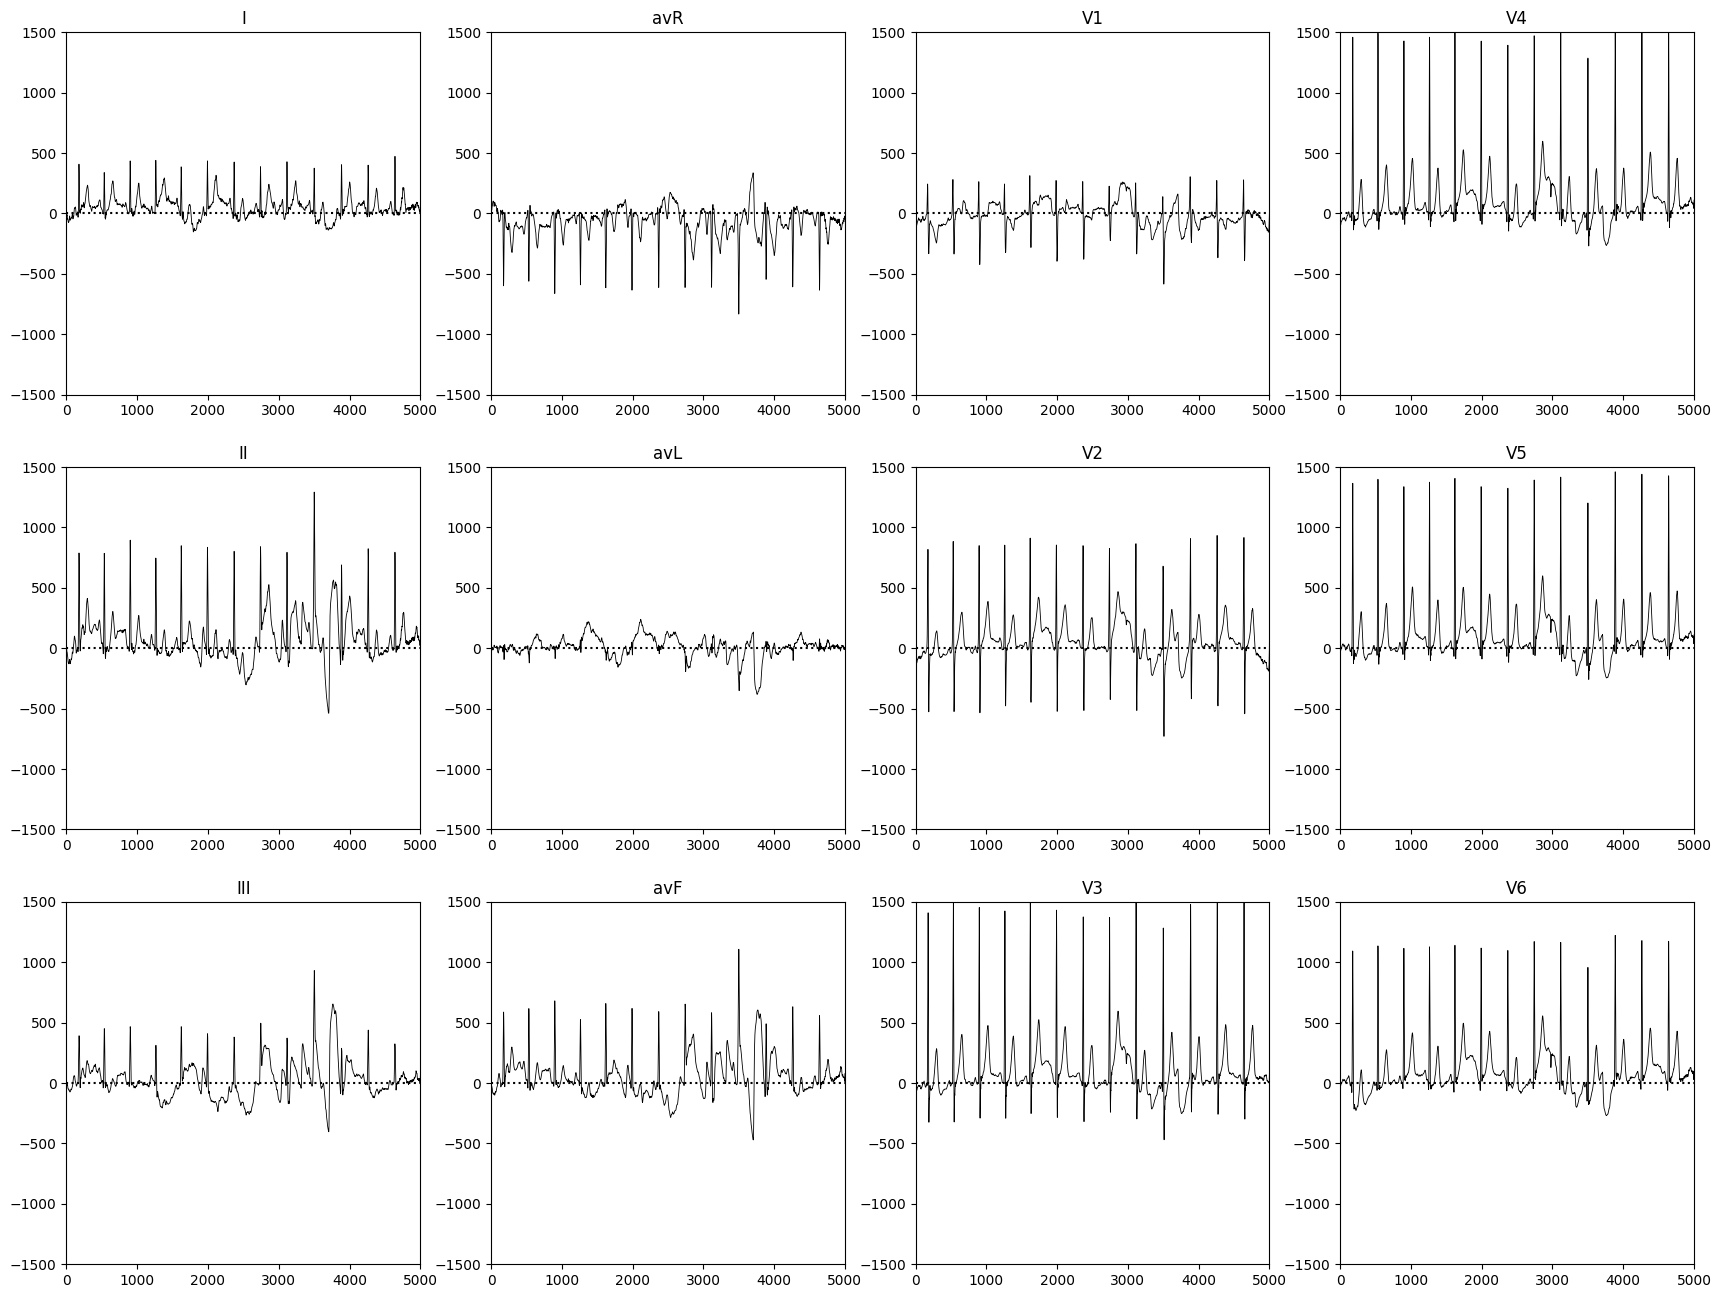

In [ ]:
_lr,_lc = 3,4
_leads = [
    [['I'],['avR'],['V1'],['V4']],
    [['II'],['avL'],['V2'],['V5']],
    [['III'],['avF'],['V3'],['V6']]
]

df__1001 = df__.loc[1001,'V1_df'].df


fig,ax = plt.subplots(_lr,_lc, figsize=(_lr*7,_lc*4))
#fig.set_dpi(150)
for i in range(0,3):
    for j in range(0,4):
        _key = _leads[i][j][0]
        ax[i,j].set_title(_key)
        ax[i,j].plot(df__1001[_key], color='black', linewidth=0.6)
        ax[i,j].set_ylim((-1500,1500))
        ax[i,j].set_xlim((0,5000))
        ax[i,j].hlines(0,0,5000,color='black',linestyle='dotted')


plt.show()

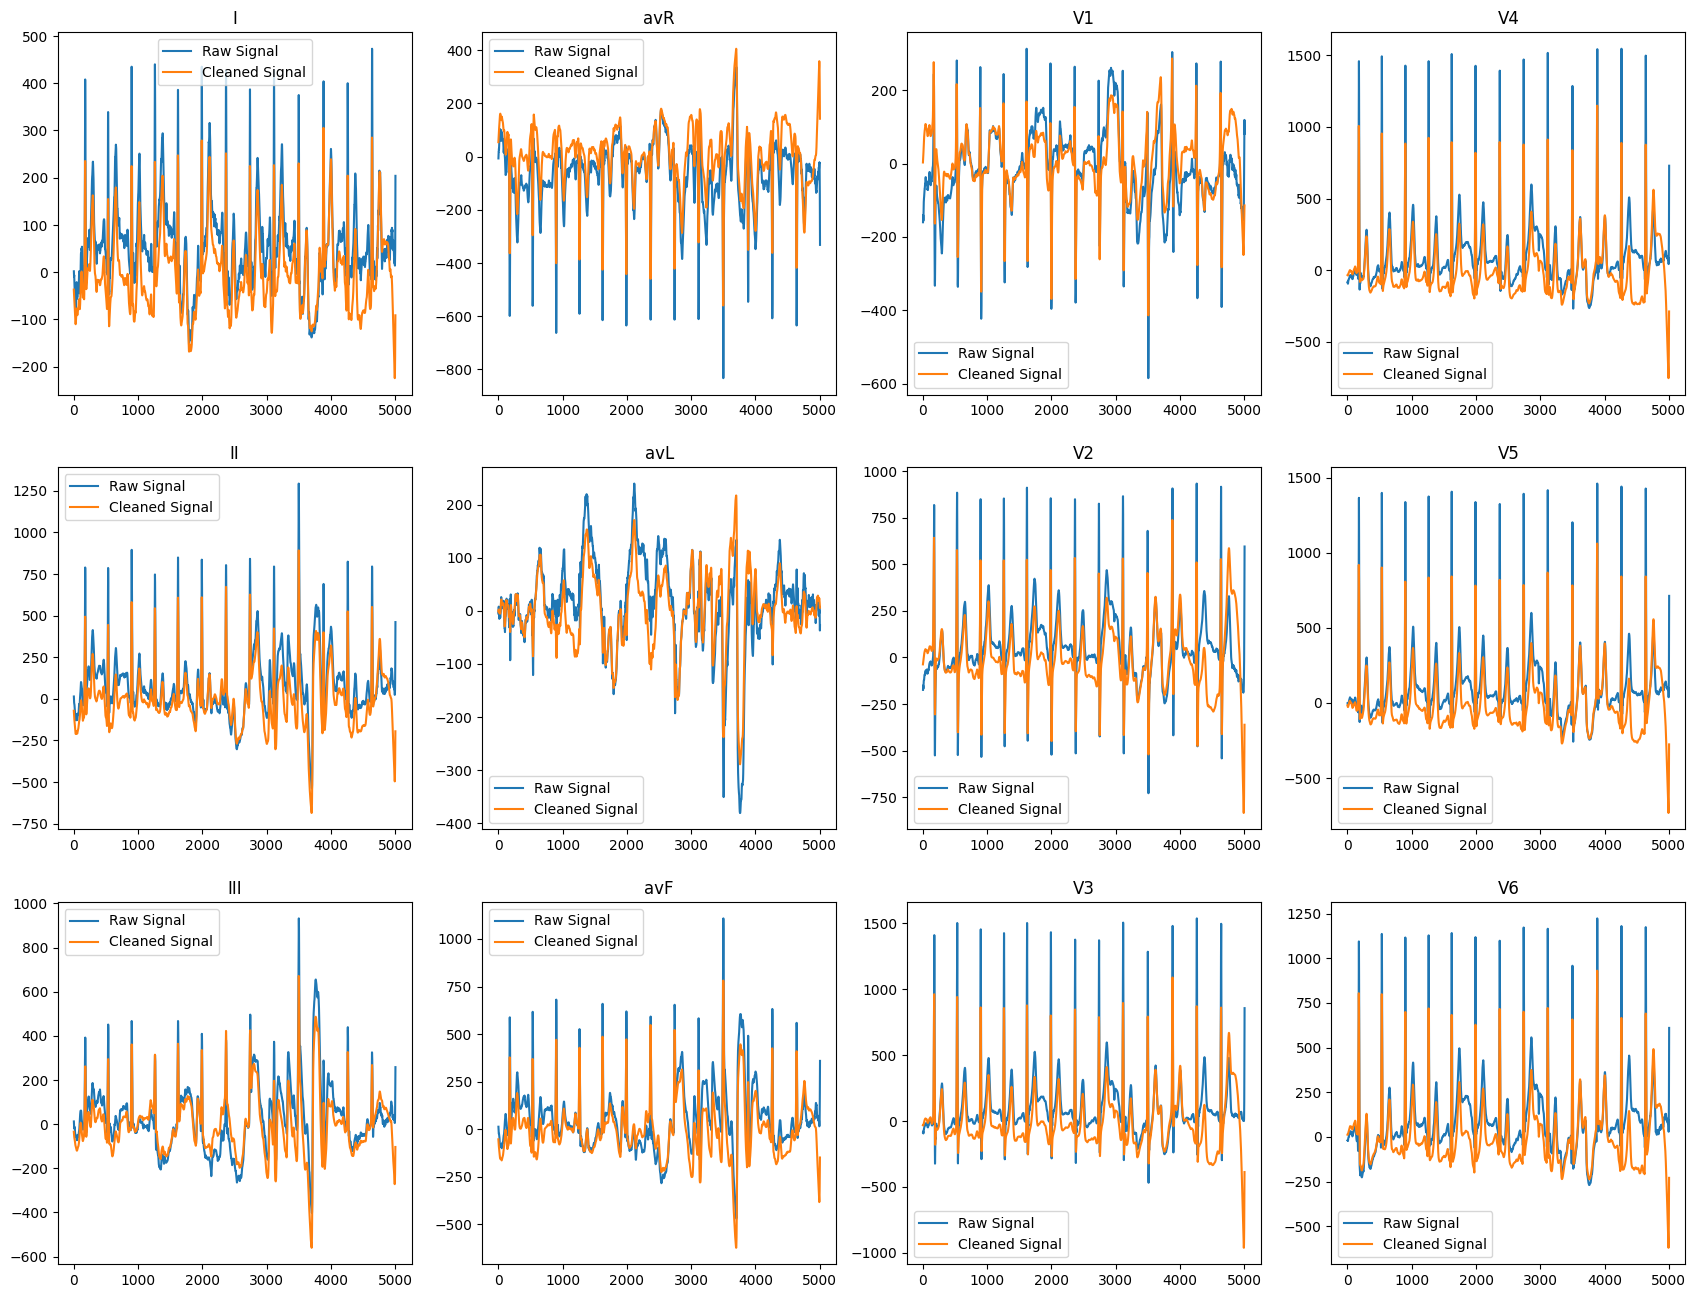

In [ ]:
from scipy import signal

df = df__.loc[1001,'V1_df'].df

fig,ax = plt.subplots(_lr,_lc, figsize=(_lr*7,_lc*4))
for i in range(0,3):
    for j in range(0,4):
        _key = _leads[i][j][0]
        ax[i,j].set_title(_key)
        sos = signal.butter(5, 0.3, 'hp', fs=2000, output='sos')
        sig = df[_key]
        sig = sig.drop([0, 5007])
        clean_sig = nk.ecg_clean(sig, 500)
        filtd=signal.sosfilt(sos, sig)
        ax[i,j].plot(sig, label='Raw Signal')
        ax[i,j].plot(clean_sig, label='Cleaned Signal')
        ax[i,j].legend(['Raw Signal', 'Cleaned Signal'])

plt.show()

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/ecg_dataset/clustered_data.pkl')
df = df.rename(columns={'v': 'target'})
df

,id,target,II_mean_nni,II_sdnn,II_sdsd,II_nni_50,II_pnni_50,II_nni_20,II_pnni_20,II_rmssd,...,V6_hfnu,V6_total_power,V6_vlf,V6_sd1,V6_sd2,V6_ratio_sd2_sd1,V6_csi,V6_cvi,V6_Modified_csi,V6_triangular_index
1,1001.0,1,713.538462,44.804418,57.377890,5.0,41.666667,9.0,75.000000,58.759396,...,69.611138,571.391278,23.238607,20.988814,52.105248,2.482525,2.482525,4.242989,517.410256,4.333333
3,1003.0,0,750.769231,71.593940,72.628430,7.0,58.333333,11.0,91.666667,74.668155,...,36.534954,1769.019335,341.079281,41.865586,83.722318,1.999789,1.999789,4.748818,669.707727,6.500000
4,1003.0,0,719.846154,91.897448,88.522439,10.0,83.333333,10.0,83.333333,91.805955,...,31.802072,1302.269253,360.248281,57.122542,137.268181,2.403047,2.403047,5.098497,1319.447828,6.500000
5,1003.0,0,774.769231,104.478191,75.229095,6.0,50.000000,9.0,75.000000,80.806353,...,84.785715,844.863216,135.844938,62.411635,134.197876,2.150206,2.150206,5.127131,1154.212356,4.333333
6,1005.0,0,778.416667,104.041476,86.415582,7.0,63.636364,11.0,100.000000,91.065411,...,38.732747,2356.171822,273.639594,57.571221,116.448038,2.022678,2.022678,5.030458,942.147503,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,1200.0,1,647.333333,38.334369,41.935081,3.0,21.428571,4.0,28.571429,41.976184,...,30.560883,87.879308,24.470261,30.475535,62.300683,2.044285,2.044285,4.482564,509.441435,2.500000
602,1200.0,0,690.142857,105.210307,69.489772,3.0,23.076923,7.0,53.846154,75.567596,...,15.447289,1521.531844,394.941700,54.643131,143.128685,2.619335,2.619335,5.097382,1499.608096,4.666667
603,1201.0,1,616.125000,27.975882,29.018308,1.0,6.666667,1.0,6.666667,29.866369,...,86.948701,108.863714,0.917718,24.333790,33.543504,1.378474,1.378474,4.115938,184.955433,2.000000
604,1201.0,1,643.933333,30.496994,30.946300,2.0,14.285714,6.0,42.857143,30.986172,...,49.774608,378.762557,41.406223,36.682331,48.912818,1.333416,1.333416,4.458000,260.884592,3.750000


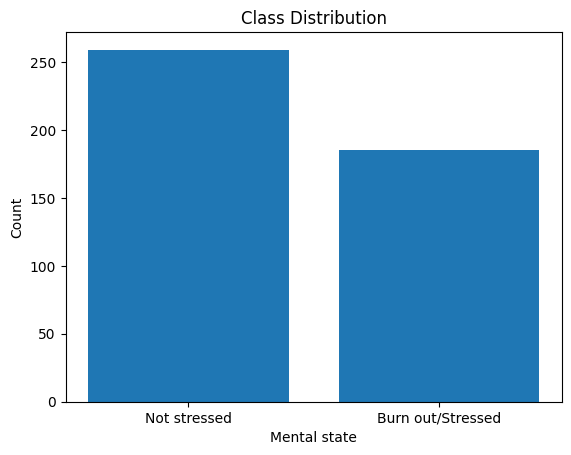

In [ ]:
target_values = df['target'].values
label_values, label_counts = np.unique(target_values, return_counts=True)
x_labels = ['Not stressed', 'Burn out/Stressed']
## burnt out == 1
# Plot a bar chart of the label frequencies using matplotlib
plt.bar(x_labels, label_counts, tick_label=x_labels)
plt.xlabel('Mental state')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

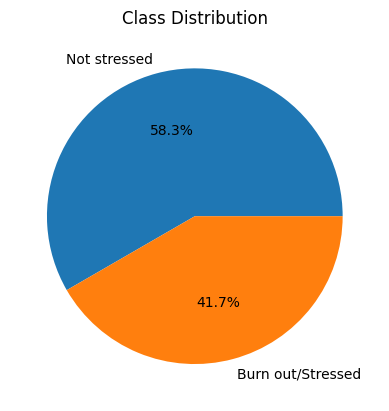

In [ ]:
import matplotlib.pyplot as plt

# assume y is your label data
classes, counts = np.unique(target_values, return_counts=True)

# plot the class distribution as a pie chart
plt.pie(counts, labels=['Not stressed', 'Burn out/Stressed'], autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()


In [ ]:
df.describe()

,id,target,II_mean_nni,II_sdnn,II_sdsd,II_nni_50,II_pnni_50,II_nni_20,II_pnni_20,II_rmssd,...,V6_hfnu,V6_total_power,V6_vlf,V6_sd1,V6_sd2,V6_ratio_sd2_sd1,V6_csi,V6_cvi,V6_Modified_csi,V6_triangular_index
count,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,...,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000
mean,1301.173267,0.234323,802.037783,88.333933,76.317907,5.216172,49.232742,8.092409,74.672713,79.947555,...,51.387928,2401.199246,352.028163,56.068200,112.177481,2.001023,2.001023,4.903872,1008.344911,5.569211
std,1401.811364,0.423925,104.632026,39.332764,26.835259,2.206183,22.374350,2.044475,18.991346,28.648314,...,24.523752,4336.843566,461.282694,21.759987,57.174020,0.735767,0.735767,0.405359,742.913480,1.963812
min,1001.000000,0.000000,611.250000,11.644026,9.022647,0.000000,0.000000,0.000000,0.000000,9.023778,...,6.404878,10.017076,0.018145,7.097438,9.013482,0.423364,0.423364,3.079663,39.011733,1.875000
25%,1054.000000,0.000000,730.302885,58.646858,58.840887,4.000000,33.333333,7.000000,66.666667,60.524442,...,31.236008,820.275395,40.666031,41.091121,66.726456,1.428562,1.428562,4.658530,396.378327,4.333333
50%,1104.500000,0.000000,795.916667,83.330957,73.782409,5.000000,50.000000,8.000000,77.777778,76.803751,...,49.820959,1620.600685,189.574583,54.199578,103.599116,1.963630,1.963630,4.947630,807.709962,5.500000
75%,1155.000000,0.000000,868.684091,117.083266,94.170483,7.000000,63.636364,9.000000,88.888889,98.639917,...,71.923273,2979.618098,491.216893,67.302529,150.274692,2.526327,2.526327,5.195035,1527.355703,6.000000
max,11149.000000,1.000000,1250.625000,196.026192,202.951349,11.000000,100.000000,12.000000,100.000000,207.353563,...,99.143942,91983.287550,4906.604499,242.908419,398.788763,4.608576,4.608576,6.190305,4020.777939,13.000000


# Data Handling

In [ ]:
import pandas as pd
df = pd.read_pickle('/content/drive/MyDrive/ecg_dataset/complete_data.pkl')
df = df.rename(columns={'v': 'target'})

In [ ]:
class_counts = df['target'].value_counts()
print(class_counts)

0.0    464
1.0    142
Name: target, dtype: int64


In [ ]:
X, y = df.drop(['target', 'id'], axis=1), df['target']

In [ ]:
X.shape

(444, 210)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
from sklearn.decomposition import PCA

# Create a PCA object with desired number of components
pca = PCA(0.95)

# Fit and transform the data using PCA
X_red = pca.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.33, random_state=42,stratify = y)

In [ ]:
y_train.value_counts()

0    173
1    124
Name: target, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.8)
X_resampled, y_resampled = over.fit_resample(X_train, y_train)

In [ ]:
y_resampled.value_counts()

0    173
1    138
Name: target, dtype: int64

In [ ]:
import numpy as np
unique_elements, counts = np.unique(y_resampled, return_counts=True)
print(counts)

[259 259]


In [ ]:
X_train = X_resampled 
y_train = y_resampled

# Clustering

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_pickle('/content/drive/MyDrive/ecg_dataset/complete_data.pkl')
df = df.rename(columns={'v': 'target'})
df

,id,target,II_mean_nni,II_sdnn,II_sdsd,II_nni_50,II_pnni_50,II_nni_20,II_pnni_20,II_rmssd,...,V6_hfnu,V6_total_power,V6_vlf,V6_sd1,V6_sd2,V6_ratio_sd2_sd1,V6_csi,V6_cvi,V6_Modified_csi,V6_triangular_index
0,1001.0,0.0,799.083333,136.617221,114.167993,8.0,72.727273,8.0,72.727273,120.268639,...,14.412212,2863.660708,899.058366,66.187612,178.448499,2.696101,2.696101,5.276410,1924.460825,4.000000
1,1001.0,0.0,713.538462,44.804418,57.377890,5.0,41.666667,9.0,75.000000,58.759396,...,69.611138,571.391278,23.238607,20.988814,52.105248,2.482525,2.482525,4.242989,517.410256,4.333333
2,1001.0,0.0,923.700000,133.059761,118.891900,5.0,55.555556,8.0,88.888889,125.369676,...,59.451054,3827.316706,518.851271,101.599705,162.849044,1.602850,1.602850,5.422798,1044.090086,10.000000
3,1003.0,0.0,750.769231,71.593940,72.628430,7.0,58.333333,11.0,91.666667,74.668155,...,36.534954,1769.019335,341.079281,41.865586,83.722318,1.999789,1.999789,4.748818,669.707727,6.500000
4,1003.0,1.0,719.846154,91.897448,88.522439,10.0,83.333333,10.0,83.333333,91.805955,...,31.802072,1302.269253,360.248281,57.122542,137.268181,2.403047,2.403047,5.098497,1319.447828,6.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,1200.0,0.0,747.923077,134.725933,95.910404,7.0,58.333333,8.0,66.666667,103.853262,...,45.790076,1634.954393,368.056664,61.823797,179.346314,2.900927,2.900927,5.248968,2081.082175,4.333333
602,1200.0,0.0,690.142857,105.210307,69.489772,3.0,23.076923,7.0,53.846154,75.567596,...,15.447289,1521.531844,394.941700,54.643131,143.128685,2.619335,2.619335,5.097382,1499.608096,4.666667
603,1201.0,1.0,616.125000,27.975882,29.018308,1.0,6.666667,1.0,6.666667,29.866369,...,86.948701,108.863714,0.917718,24.333790,33.543504,1.378474,1.378474,4.115938,184.955433,2.000000
604,1201.0,0.0,643.933333,30.496994,30.946300,2.0,14.285714,6.0,42.857143,30.986172,...,49.774608,378.762557,41.406223,36.682331,48.912818,1.333416,1.333416,4.458000,260.884592,3.750000


In [ ]:
cls_data = df.loc[:, 'II_mean_nni':'V6_triangular_index']
cls_data

,II_mean_nni,II_sdnn,II_sdsd,II_nni_50,II_pnni_50,II_nni_20,II_pnni_20,II_rmssd,II_median_nni,II_range_nni,...,V6_hfnu,V6_total_power,V6_vlf,V6_sd1,V6_sd2,V6_ratio_sd2_sd1,V6_csi,V6_cvi,V6_Modified_csi,V6_triangular_index
0,799.083333,136.617221,114.167993,8.0,72.727273,8.0,72.727273,120.268639,752.0,482.0,...,14.412212,2863.660708,899.058366,66.187612,178.448499,2.696101,2.696101,5.276410,1924.460825,4.000000
1,713.538462,44.804418,57.377890,5.0,41.666667,9.0,75.000000,58.759396,714.0,152.0,...,69.611138,571.391278,23.238607,20.988814,52.105248,2.482525,2.482525,4.242989,517.410256,4.333333
2,923.700000,133.059761,118.891900,5.0,55.555556,8.0,88.888889,125.369676,944.0,466.0,...,59.451054,3827.316706,518.851271,101.599705,162.849044,1.602850,1.602850,5.422798,1044.090086,10.000000
3,750.769231,71.593940,72.628430,7.0,58.333333,11.0,91.666667,74.668155,764.0,250.0,...,36.534954,1769.019335,341.079281,41.865586,83.722318,1.999789,1.999789,4.748818,669.707727,6.500000
4,719.846154,91.897448,88.522439,10.0,83.333333,10.0,83.333333,91.805955,683.0,326.0,...,31.802072,1302.269253,360.248281,57.122542,137.268181,2.403047,2.403047,5.098497,1319.447828,6.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,747.923077,134.725933,95.910404,7.0,58.333333,8.0,66.666667,103.853262,728.0,492.0,...,45.790076,1634.954393,368.056664,61.823797,179.346314,2.900927,2.900927,5.248968,2081.082175,4.333333
602,690.142857,105.210307,69.489772,3.0,23.076923,7.0,53.846154,75.567596,650.0,386.0,...,15.447289,1521.531844,394.941700,54.643131,143.128685,2.619335,2.619335,5.097382,1499.608096,4.666667
603,616.125000,27.975882,29.018308,1.0,6.666667,1.0,6.666667,29.866369,611.0,118.0,...,86.948701,108.863714,0.917718,24.333790,33.543504,1.378474,1.378474,4.115938,184.955433,2.000000
604,643.933333,30.496994,30.946300,2.0,14.285714,6.0,42.857143,30.986172,636.0,118.0,...,49.774608,378.762557,41.406223,36.682331,48.912818,1.333416,1.333416,4.458000,260.884592,3.750000


In [ ]:
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# data= X_new
data_scaled = scaler.fit_transform(cls_data)

# statistics of scaled data
pd.DataFrame(data_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
count,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,...,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02,6.060000e+02
mean,-4.572800e-16,3.283036e-16,2.462277e-16,-1.377702e-16,5.276307e-17,-3.019220e-16,-1.407015e-16,5.862564e-18,-2.931282e-17,-5.276307e-17,...,9.380102e-17,-6.155692e-17,-2.931282e-17,-5.862564e-18,-5.510810e-16,7.650646e-16,7.650646e-16,-3.576164e-16,-8.207589e-17,-2.345026e-17
std,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,...,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00,1.000826e+00
min,-1.824923e+00,-1.951382e+00,-2.509790e+00,-2.366296e+00,-2.202228e+00,-3.961455e+00,-3.935182e+00,-2.477715e+00,-1.695473e+00,-2.003263e+00,...,-1.835780e+00,-5.518201e-01,-7.637417e-01,-2.252355e+00,-1.805877e+00,-2.146008e+00,-2.146008e+00,-4.503954e+00,-1.305851e+00,-1.882697e+00
25%,-6.861585e-01,-7.553906e-01,-6.518088e-01,-5.517115e-01,-7.111958e-01,-5.347641e-01,-4.219111e-01,-6.785446e-01,-6.858071e-01,-8.148587e-01,...,-8.224096e-01,-3.648344e-01,-6.755496e-01,-6.888539e-01,-7.956161e-01,-7.786891e-01,-7.786891e-01,-6.057467e-01,-8.244192e-01,-6.298455e-01
50%,-5.854969e-02,-1.273012e-01,-9.456189e-02,-9.806540e-02,3.432017e-02,-4.523685e-02,1.636340e-01,-1.098285e-01,-9.082558e-02,-8.526898e-02,...,-6.394874e-02,-1.801410e-01,-3.524689e-01,-8.594517e-02,-1.501635e-01,-5.086339e-02,-5.086339e-02,1.080382e-01,-2.702881e-01,-3.527214e-02
75%,6.374852e-01,7.315297e-01,6.658152e-01,8.092267e-01,6.442878e-01,4.442905e-01,7.491791e-01,6.530159e-01,5.897972e-01,7.496223e-01,...,8.380573e-01,1.334834e-01,3.019921e-01,5.167103e-01,6.668883e-01,7.145450e-01,7.145450e-01,7.188765e-01,6.991925e-01,2.195450e-01
max,4.290826e+00,2.740240e+00,4.722818e+00,2.623811e+00,2.270868e+00,1.912872e+00,1.334724e+00,4.450917e+00,3.893748e+00,3.036172e+00,...,1.948946e+00,2.067312e+01,9.881877e+00,8.593505e+00,5.017105e+00,3.546921e+00,3.546921e+00,3.176189e+00,4.058241e+00,3.786985e+00


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 1)
pC = pca.fit_transform(data_scaled)
principalDf = pd.DataFrame(data = pC, columns = ['feature1'])
principalDf

,feature1
0,8.218444
1,-9.639311
2,12.456891
3,0.736971
4,0.617112
...,...
601,6.017171
602,0.643925
603,-18.148493
604,-15.633765


In [ ]:
# k means using 2 clusters and k-means++ initialization
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 3, init='k-means++')
kmeans.fit(principalDf)
pred = kmeans.predict(principalDf)
frame = pd.DataFrame(principalDf)
frame['cluster'] = pred
frame['target'] = df['target'].astype(int)
frame
print(frame['target'].value_counts())
frame['cluster'].value_counts()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    464
1    142
Name: target, dtype: int64


2    259
0    185
1    162
Name: cluster, dtype: int64

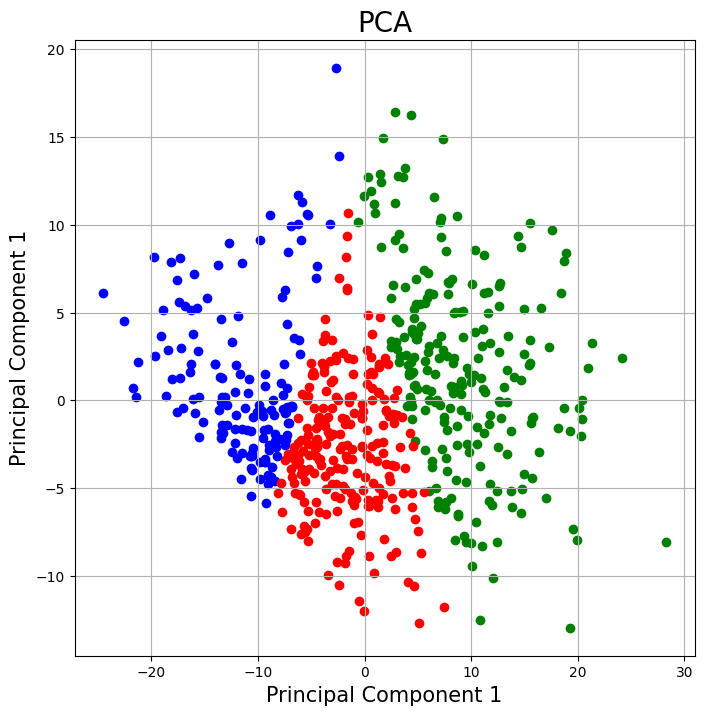

In [ ]:

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 1', fontsize = 15)
ax.set_title('PCA', fontsize = 20)

colors = ['r', 'g', 'b']
for i in frame.index:
    ax.scatter(frame.loc[i, 'feature1'],
               frame.loc[i, 'feature2']
                , c = colors[frame.loc[i,'cluster']]
                )
ax.grid()

In [ ]:
print(frame['target'].value_counts())
frame['cluster'].value_counts()


0    464
1    142
Name: target, dtype: int64


0    259
1    185
3    162
Name: cluster, dtype: int64

In [ ]:
frame['cluster'].replace(0, 3, inplace=True)
frame['cluster'].replace(2, 0, inplace=True)
frame['cluster'].replace(3, 2, inplace=True)

In [ ]:
from sklearn.metrics import accuracy_score, silhouette_score
print('Accuracy:', accuracy_score(frame['target'], frame['cluster']))
print('Silhoutte score:', silhouette_score(frame, frame['cluster']))

Accuracy: 0.5558194774346793
Silhoutte score: 0.5923173359272569


In [ ]:
frame = frame[frame['cluster'] != 2]
frame

,feature1,cluster,target
0,8.218444,1,0
2,12.456891,1,0
3,0.736971,0,0
4,0.617112,0,1
5,2.178703,0,0
...,...,...,...
592,8.458295,1,0
594,-2.499961,0,0
596,16.579354,1,0
601,6.017171,1,0


In [ ]:
new_df = df[df.index.isin(frame.index)]
new_df

,id,target,II_mean_nni,II_sdnn,II_sdsd,II_nni_50,II_pnni_50,II_nni_20,II_pnni_20,II_rmssd,...,V6_hfnu,V6_total_power,V6_vlf,V6_sd1,V6_sd2,V6_ratio_sd2_sd1,V6_csi,V6_cvi,V6_Modified_csi,V6_triangular_index
1,1001.0,0.0,713.538462,44.804418,57.377890,5.0,41.666667,9.0,75.000000,58.759396,...,69.611138,571.391278,23.238607,20.988814,52.105248,2.482525,2.482525,4.242989,517.410256,4.333333
3,1003.0,0.0,750.769231,71.593940,72.628430,7.0,58.333333,11.0,91.666667,74.668155,...,36.534954,1769.019335,341.079281,41.865586,83.722318,1.999789,1.999789,4.748818,669.707727,6.500000
4,1003.0,1.0,719.846154,91.897448,88.522439,10.0,83.333333,10.0,83.333333,91.805955,...,31.802072,1302.269253,360.248281,57.122542,137.268181,2.403047,2.403047,5.098497,1319.447828,6.500000
5,1003.0,0.0,774.769231,104.478191,75.229095,6.0,50.000000,9.0,75.000000,80.806353,...,84.785715,844.863216,135.844938,62.411635,134.197876,2.150206,2.150206,5.127131,1154.212356,4.333333
6,1005.0,0.0,778.416667,104.041476,86.415582,7.0,63.636364,11.0,100.000000,91.065411,...,38.732747,2356.171822,273.639594,57.571221,116.448038,2.022678,2.022678,5.030458,942.147503,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,1200.0,0.0,647.333333,38.334369,41.935081,3.0,21.428571,4.0,28.571429,41.976184,...,30.560883,87.879308,24.470261,30.475535,62.300683,2.044285,2.044285,4.482564,509.441435,2.500000
602,1200.0,0.0,690.142857,105.210307,69.489772,3.0,23.076923,7.0,53.846154,75.567596,...,15.447289,1521.531844,394.941700,54.643131,143.128685,2.619335,2.619335,5.097382,1499.608096,4.666667
603,1201.0,1.0,616.125000,27.975882,29.018308,1.0,6.666667,1.0,6.666667,29.866369,...,86.948701,108.863714,0.917718,24.333790,33.543504,1.378474,1.378474,4.115938,184.955433,2.000000
604,1201.0,0.0,643.933333,30.496994,30.946300,2.0,14.285714,6.0,42.857143,30.986172,...,49.774608,378.762557,41.406223,36.682331,48.912818,1.333416,1.333416,4.458000,260.884592,3.750000


In [ ]:
new_df['target'] = frame['cluster']
new_df

<ipython-input-293-5e17ccce3dad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['target'] = frame['cluster']


,id,target,II_mean_nni,II_sdnn,II_sdsd,II_nni_50,II_pnni_50,II_nni_20,II_pnni_20,II_rmssd,...,V6_hfnu,V6_total_power,V6_vlf,V6_sd1,V6_sd2,V6_ratio_sd2_sd1,V6_csi,V6_cvi,V6_Modified_csi,V6_triangular_index
1,1001.0,1,713.538462,44.804418,57.377890,5.0,41.666667,9.0,75.000000,58.759396,...,69.611138,571.391278,23.238607,20.988814,52.105248,2.482525,2.482525,4.242989,517.410256,4.333333
3,1003.0,0,750.769231,71.593940,72.628430,7.0,58.333333,11.0,91.666667,74.668155,...,36.534954,1769.019335,341.079281,41.865586,83.722318,1.999789,1.999789,4.748818,669.707727,6.500000
4,1003.0,0,719.846154,91.897448,88.522439,10.0,83.333333,10.0,83.333333,91.805955,...,31.802072,1302.269253,360.248281,57.122542,137.268181,2.403047,2.403047,5.098497,1319.447828,6.500000
5,1003.0,0,774.769231,104.478191,75.229095,6.0,50.000000,9.0,75.000000,80.806353,...,84.785715,844.863216,135.844938,62.411635,134.197876,2.150206,2.150206,5.127131,1154.212356,4.333333
6,1005.0,0,778.416667,104.041476,86.415582,7.0,63.636364,11.0,100.000000,91.065411,...,38.732747,2356.171822,273.639594,57.571221,116.448038,2.022678,2.022678,5.030458,942.147503,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,1200.0,1,647.333333,38.334369,41.935081,3.0,21.428571,4.0,28.571429,41.976184,...,30.560883,87.879308,24.470261,30.475535,62.300683,2.044285,2.044285,4.482564,509.441435,2.500000
602,1200.0,0,690.142857,105.210307,69.489772,3.0,23.076923,7.0,53.846154,75.567596,...,15.447289,1521.531844,394.941700,54.643131,143.128685,2.619335,2.619335,5.097382,1499.608096,4.666667
603,1201.0,1,616.125000,27.975882,29.018308,1.0,6.666667,1.0,6.666667,29.866369,...,86.948701,108.863714,0.917718,24.333790,33.543504,1.378474,1.378474,4.115938,184.955433,2.000000
604,1201.0,1,643.933333,30.496994,30.946300,2.0,14.285714,6.0,42.857143,30.986172,...,49.774608,378.762557,41.406223,36.682331,48.912818,1.333416,1.333416,4.458000,260.884592,3.750000


In [ ]:
new_df

,id,target,II_mean_nni,II_sdnn,II_sdsd,II_nni_50,II_pnni_50,II_nni_20,II_pnni_20,II_rmssd,...,V6_hfnu,V6_total_power,V6_vlf,V6_sd1,V6_sd2,V6_ratio_sd2_sd1,V6_csi,V6_cvi,V6_Modified_csi,V6_triangular_index
1,1001.0,1,713.538462,44.804418,57.377890,5.0,41.666667,9.0,75.000000,58.759396,...,69.611138,571.391278,23.238607,20.988814,52.105248,2.482525,2.482525,4.242989,517.410256,4.333333
3,1003.0,0,750.769231,71.593940,72.628430,7.0,58.333333,11.0,91.666667,74.668155,...,36.534954,1769.019335,341.079281,41.865586,83.722318,1.999789,1.999789,4.748818,669.707727,6.500000
4,1003.0,0,719.846154,91.897448,88.522439,10.0,83.333333,10.0,83.333333,91.805955,...,31.802072,1302.269253,360.248281,57.122542,137.268181,2.403047,2.403047,5.098497,1319.447828,6.500000
5,1003.0,0,774.769231,104.478191,75.229095,6.0,50.000000,9.0,75.000000,80.806353,...,84.785715,844.863216,135.844938,62.411635,134.197876,2.150206,2.150206,5.127131,1154.212356,4.333333
6,1005.0,0,778.416667,104.041476,86.415582,7.0,63.636364,11.0,100.000000,91.065411,...,38.732747,2356.171822,273.639594,57.571221,116.448038,2.022678,2.022678,5.030458,942.147503,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,1200.0,1,647.333333,38.334369,41.935081,3.0,21.428571,4.0,28.571429,41.976184,...,30.560883,87.879308,24.470261,30.475535,62.300683,2.044285,2.044285,4.482564,509.441435,2.500000
602,1200.0,0,690.142857,105.210307,69.489772,3.0,23.076923,7.0,53.846154,75.567596,...,15.447289,1521.531844,394.941700,54.643131,143.128685,2.619335,2.619335,5.097382,1499.608096,4.666667
603,1201.0,1,616.125000,27.975882,29.018308,1.0,6.666667,1.0,6.666667,29.866369,...,86.948701,108.863714,0.917718,24.333790,33.543504,1.378474,1.378474,4.115938,184.955433,2.000000
604,1201.0,1,643.933333,30.496994,30.946300,2.0,14.285714,6.0,42.857143,30.986172,...,49.774608,378.762557,41.406223,36.682331,48.912818,1.333416,1.333416,4.458000,260.884592,3.750000


In [ ]:
new_df.to_pickle('clustered_data.pkl')

# Classification

Max Accuracy: 0.70


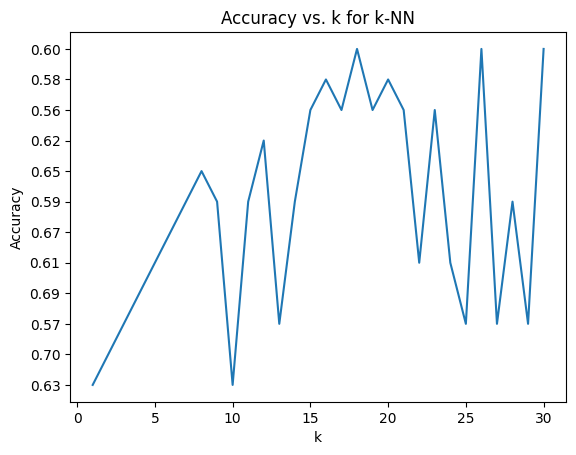

2


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

accuracies = []
k_values = range(1, 31)
for i in k_values:
    knn_clf = KNeighborsClassifier(n_neighbors=i)
    knn_clf.fit(X_train, y_train)
    # knn_clf_pred = knn_clf.predict(X_test)
    accuracy = knn_clf.score(X_test, y_test)
    accuracies.append(f'{accuracy:.2f}')
accuracy = max(accuracies)
k = accuracies.index(max(accuracies))+1
print(f'Max Accuracy: {accuracy}')
plt.plot(k_values, accuracies)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k for k-NN')
plt.show()
print(k)

knn_clf = KNeighborsClassifier(n_neighbors=k)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train and evaluate a decision tree model
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
# print(y_pred_dt)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

# Train and evaluate a random forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
# print(y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)


# Print the accuracies of each model
print(f'Decision tree accuracy: {accuracy_dt:.2f}')
print(f'Random forest accuracy: {accuracy_rf:.2f}')


Decision tree accuracy: 0.65
Random forest accuracy: 0.76


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters grid
param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create a k-NN classifier object
knn = KNeighborsClassifier()

# Perform a grid search to find the best hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy on the testing set
print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'Testing accuracy: {grid_search.score(X_test, y_test):.2f}')


Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Testing accuracy: 0.61


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf1 = RandomForestClassifier(n_estimators = 100,criterion='gini',min_samples_leaf=10,min_samples_split=20,class_weight='balanced') 
rf1.fit(X_train,y_train)
print("ACCURACY OF THE MODEL: ", round(accuracy_score(y_test, rf1.predict(X_test)),2)) 

ACCURACY OF THE MODEL:  0.69


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# try
kernels = ['poly', 'rbf', 'sigmoid']

kernel = 'poly'
svm = SVC(kernel=kernel)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'SVM accuracy with {kernel} kernel: {accuracy:.2f}')


SVM accuracy with poly kernel: 0.74


In [ ]:
from sklearn.naive_bayes import GaussianNB  
classifier = GaussianNB()  
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)  
accuracy = accuracy_score(y_test, y_pred)
from sklearn.metrics import confusion_matrix  
cm = confusion_matrix(y_test, y_pred)
print(accuracy)
print(cm)


0.8571428571428571
[[70 16]
 [ 5 56]]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# create a Random Forest Classifier object
rfc = SVC(kernel='rbf')

# create a 5-fold stratified cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# initialize lists to store the evaluation metrics for each fold
acc_list = []
f1_list = []
precision_list = []
recall_list = []
auc_list = []

# loop over the folds and train/test the classifier
for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    # get the train and test data for this fold
    
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # fit the classifier on the train data
    rfc.fit(X_train_fold, y_train_fold)

    # predict the labels on the test data
    y_pred = rfc.predict(X_test_fold)

    # compute the evaluation metrics
    acc = accuracy_score(y_test_fold, y_pred)
    f1 = f1_score(y_test_fold, y_pred)
    precision = precision_score(y_test_fold, y_pred)
    recall = recall_score(y_test_fold, y_pred)
    auc = roc_auc_score(y_test_fold, y_pred)

    # append the evaluation metrics to the lists
    acc_list.append(acc)
    f1_list.append(f1)
    precision_list.append(precision)
    recall_list.append(recall)
    auc_list.append(auc)

    # print the evaluation metrics for this fold
    print(f"Fold {fold + 1}: Accuracy = {acc:.3f}, F1 Score = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}, AUC = {auc:.3f}")

# print the mean evaluation metrics across all folds
print(f"\nAcross folds: Accuracy = {np.mean(acc_list):.3f}, F1 Score = {np.mean(f1_list):.3f}, Precision = {np.mean(precision_list):.3f}, Recall = {np.mean(recall_list):.3f}, AUC = {np.mean(auc_list):.3f}")


Fold 1: Accuracy = 0.971, F1 Score = 0.972, Precision = 0.946, Recall = 1.000, AUC = 0.971
Fold 2: Accuracy = 1.000, F1 Score = 1.000, Precision = 1.000, Recall = 1.000, AUC = 1.000
Fold 3: Accuracy = 0.971, F1 Score = 0.971, Precision = 0.971, Recall = 0.971, AUC = 0.971
Fold 4: Accuracy = 0.971, F1 Score = 0.971, Precision = 0.971, Recall = 0.971, AUC = 0.971
Fold 5: Accuracy = 0.971, F1 Score = 0.970, Precision = 1.000, Recall = 0.941, AUC = 0.971

Across folds: Accuracy = 0.977, F1 Score = 0.977, Precision = 0.978, Recall = 0.977, AUC = 0.977


## Evaluation Metrics

In [ ]:
##Metrics
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
y_true = y_test
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# compute classification report with precision, recall, and F1 score
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

#compute accuracy
acc = accuracy_score(y_pred, y_true)
print("Accuracy: ", acc)
# compute F1 score
f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1}")

# compute precision
precision = precision_score(y_true, y_pred)
print(f"Precision: {precision}")

# compute recall
recall = recall_score(y_true, y_pred)
print(f"Recall: {recall}")

# compute AUC
auc = roc_auc_score(y_true, y_pred)
print(f"AUC: {auc}")

Confusion Matrix:
[[70 16]
 [ 5 56]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87        86
           1       0.78      0.92      0.84        61

    accuracy                           0.86       147
   macro avg       0.86      0.87      0.86       147
weighted avg       0.87      0.86      0.86       147

Accuracy:  0.8571428571428571
F1 Score: 0.8421052631578947
Precision: 0.7777777777777778
Recall: 0.9180327868852459
AUC: 0.8659931376286695


# Using spectogram data

In [ ]:
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL as pil
import numpy as np
import cv2
import sys
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
from tensorflow import keras
import PIL as pil
import multiprocessing as mp
import pickle
from keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class df_holder:
    def __init__(self, df): 
        self.df = df

lead_data = pd.read_pickle("/content/drive/MyDrive/ecg_dataset/class_dataset.pkl")

In [ ]:
train_1 = lead_data.loc[:, ['V1', 'V1_df', 'V2', 'V2_df']]
test = lead_data.loc[:, ['V3', 'V3_df']]
a_df = pd.concat([train_1['V1'], train_1['V2']])
b_df = pd.concat([train_1['V1_df'], train_1['V2_df']])

In [ ]:
# create new dataframe with concatenated columns
train = pd.DataFrame({'target': a_df.values, 'df_holder': b_df.values})
train
test = test.rename(columns={'V3': 'target', 'V3_df': 'df_holder'})
test
X_train_, y_train = train['df_holder'].values, train['target'].values
X_test_, y_test = test['df_holder'].values, test['target'].values

In [ ]:
import numpy as np
X_test = np.zeros((202, 5000, 12))
X_train = np.zeros((404, 5000, 12))
print(X_test.shape)
for i in range(len(X_test)):
    X_test[i] = X_test_[i].df[1:5001].values.astype(float)
for i in range(len(X_train)):
    X_train[i] = X_train_[i].df[1:5001].values.astype(float)

(202, 5000, 12)


In [ ]:
print(train['target'].value_counts())

0    301
1    103
Name: target, dtype: int64


In [ ]:
# Separating classes
from sklearn.utils import resample
burntout = train[train['target'].values == 1]
not_burntout = train[train['target'].values == 0]

undersample = resample(burntout, 
                       replace=True, 
                       n_samples=len(not_burntout), #set the number of samples to equal the number of the minority class
                       random_state=42)
# Returning to new training set
train_balanced = pd.concat([not_burntout, undersample])

print(train_balanced['target'].value_counts())

X_train_, y_train = train_balanced['df_holder'].values, train_balanced['target'].values

import numpy as np
X_test = np.zeros((202, 5000, 12))
X_train = np.zeros((404, 5000, 12))
print(X_test.shape)
for i in range(len(X_test)):
    X_test[i] = X_test_[i].df[1:5001].values.astype(float)
for i in range(len(X_train)):
    X_train[i] = X_train_[i].df[1:5001].values.astype(float)

0    301
1    301
Name: target, dtype: int64
(202, 5000, 12)


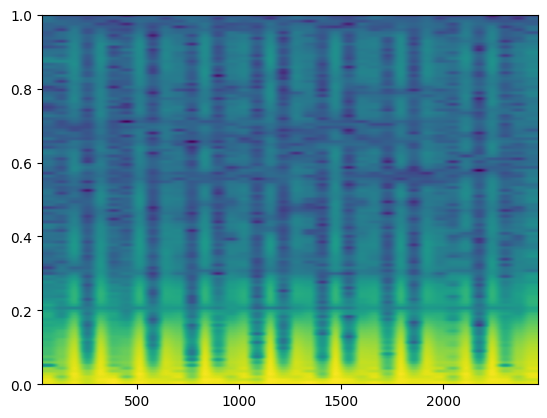

In [ ]:
# os.mkdir('drive/MyDrive/Spectrograms/train')
import numpy as np
from scipy.signal import spectrogram

X_train_spec = []
y_train_spec = []
for j in range(len(X_train)):
  # os.mkdir(f'drive/MyDrive/Spectrograms/train/Participant{j+1}')
  for i in range(12):
    data = pd.DataFrame(X_train[j])
    data = data.iloc[:,i]
    # plt.figure()

    fs = 500

    f, t, Sxx = spectrogram(data, fs=fs)
    spectrogram_array = np.array(Sxx)

    X_train_spec.append(spectrogram_array)
    y_train_spec.append(y_train[j])
    # plt.show()
    # plt.savefig(f'drive/MyDrive/Spectrograms/train/Participant{j+1}/lead{i+1}.png')

X_train_spec = np.array(X_train_spec)
y_train_spec = np.array(y_train_spec)

In [ ]:
with open('/content/drive/MyDrive/ecg_dataset/spectogram_train_X', 'wb') as f:
  pickle.dump(X_train_spec,f)
with open('/content/drive/MyDrive/ecg_dataset/spectogram_train_y', 'wb') as f:
  pickle.dump(y_train_spec,f)

In [ ]:
# os.mkdir('drive/MyDrive/Spectrograms/train')
import numpy as np
from scipy.signal import spectrogram

X_test_spec = []
y_test_spec = []
for j in range(len(X_test)):
  # os.mkdir(f'drive/MyDrive/Spectrograms/train/Participant{j+1}')
  for i in range(12):
    data = pd.DataFrame(X_test[j])
    data = data.iloc[:,i]
    # plt.figure()
    fs = 500

    f, t, Sxx = spectrogram(data, fs=fs)
    spectrogram_array = np.array(Sxx)

    X_test_spec.append(spectrogram_array)
    y_test_spec.append(y_test[j])
    # plt.show()
    # plt.savefig(f'drive/MyDrive/Spectrograms/train/Participant{j+1}/lead{i+1}.png')

X_test_spec = np.array(X_test_spec)
y_test_spec = np.array(y_test_spec)

In [ ]:
with open('/content/drive/MyDrive/ecg_dataset/spectogram_test_X', 'wb') as f:
  pickle.dump(X_test_spec,f)
with open('/content/drive/MyDrive/ecg_dataset/spectogram_test_y', 'wb') as f:
  pickle.dump(y_test_spec,f)

In [ ]:
train_path = os.listdir("/content/drive/MyDrive/Spectrograms/train")
test_path = os.listdir("/content/drive/MyDrive/Spectrograms/test")

In [ ]:
def process_image(path):
  img = pil.Image.open(path)
  img = img.resize((224,224))
  img = data = np.asarray(img)
  return data

In [ ]:
import cv2
from google.colab.patches import cv2_imshow



Participant1


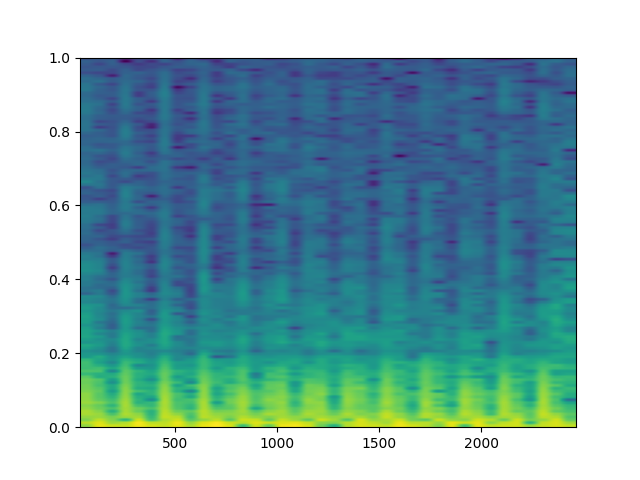

[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 25

In [ ]:
from PIL import Image
train_data = []
for i in train_path:
  print(i)
  participant_path = os.listdir("/content/drive/MyDrive/Spectrograms/train/"+i)
  input_vector = []
  #with mp.Pool(processes=8) as pool:
  input_paths = [f"/content/drive/MyDrive/Spectrograms/train/{i}/{j}" for j in participant_path]
#   input_vector = pool.map(process_image, input_paths[0])
  img = cv2.imread(input_paths[0])
  img_array = np.array(img)
  cv2_imshow(img)
  pl = Image.open(input_paths[0])
  input_vector = np.asarray(pl)
  print(img_array[:,:,0][0])
  print(input_vector)
  break
  array = np.array(input_vector)
  train_data.append(array)

train_data = np.array(train_data)

In [ ]:
from PIL import Image
test_data = []
test_label = []
for i in test_path:
  print(i)
  participant_path = os.listdir("/content/drive/MyDrive/Spectrograms/test/"+i)
  input_vector = []
  input_paths = [f"/content/drive/MyDrive/Spectrograms/test/{i}/{j}" for j in participant_path]
  for image in input_paths:
    input_vector = np.asarray(Image.open(image))   

    array = np.array(input_vector)
    test_data.append(array)
    test_label.append(y_test[i])
test_data = np.array(test_data)
test_label = np.array(test_label)

In [ ]:
file_name_test = "/content/drive/MyDrive/Spectrograms/test_set"
file_name_train = "/content/drive/MyDrive/Spectrograms/train_set"

train_set = train_data

with open(file_name_train, 'wb') as f:
  pickle.dump(train_data,f)

test_set = test_data

with open(file_name_test, 'wb') as f:
  pickle.dump(test_data,f)

In [ ]:
new_y_train = []
for i in range(len(y_train)):
  temp = [y_train[i]]*12
  new_y_train.append(temp)

y_train = np.array(new_y_train)

In [ ]:
len(y_train)
y_train = y_train.flatten()
len(y_train)

4848

In [ ]:
new_y_test = []
for i in range(len(y_test)):
  temp = [y_test[i]]*12
  new_y_test.append(temp)

y_test = np.array(new_y_test)

In [ ]:
with open('/content/drive/MyDrive/Spectrograms/train_set', 'rb') as f:
    train_data = pickle.load(f)

with open('/content/drive/MyDrive/Spectrograms/test_set', 'rb') as f:
    test_data = pickle.load(f)

In [ ]:
train_data.shape

(404, 12, 224, 224, 3)

In [ ]:
X_train = []

for i in range(len(train_data)):
  for j in range(len(train_data[0])):
    X_train.append(train_data[i][j])

len(X_train)
X_train = np.array(X_train)
# X_test, y_test = test_set

In [ ]:
vgg_model = VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
input_shape = (12, 224, 224, 3)
input_tensor = Input(shape=input_shape)

# Reshape input tensor to have the correct shape
# x = tf.reshape(input_tensor, [-1, input_shape[1], input_shape[2], input_shape[3]])


input_tensor = Input(shape=(224, 224, 3))
vgg_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Add your own layers on top of the VGG16 model here
# ...

# model = Model(inputs=input_tensor, outputs=...)


In [ ]:
for layer in vgg_model.layers:
  layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)


0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
# logits = Dense(12, activation='sigmoid')(x)
x = Dense(1, activation='sigmoid')(x) # Softmax for multiclass
transfer_model = keras.Model(inputs=vgg_model.input, outputs=x)

In [ ]:
X_train = np.zeros((4848, 224, 224, 3))
X_test = np.zeros((2424, 224, 224, 3))
for i in range(4848):
    # resize each image to (224, 224) and convert to RGB format
    img = X_train_spec[i]
    img = cv2.resize(img, (224, 224))
    X_train[:, :, :, 0] = img
    X_train[:, :, :, 1] = img
    X_train[:, :, :, 2] = img
for i in range(2424):
    # resize each image to (224, 224) and convert to RGB format
    img = X_test_spec[i]
    img = cv2.resize(img, (224, 224))
    X_test[:, :, :, 0] = img
    X_test[:, :, :, 1] = img
    X_test[:, :, :, 2] = img

In [ ]:
learning_rate= 5e-5

transfer_model.compile(loss="binary_crossentropy",optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])
history = transfer_model.fit(X_train_spec, y_train_spec, batch_size = 12, epochs=30, validation_data=(X_test_spec, y_test_spec))

In [ ]:
X_test = []

for i in range(len(test_data)):
  for j in range(len(test_data[0])):
    X_test.append(test_data[i][j])

len(X_test)
X_test = np.array(X_test)

predictions = transfer_model.predict(X_test)

76/76 [==============================] - 19s 190ms/step


In [ ]:
y_pred = []

i = 0
z = 0

while i < len(predictions):
    mean = 0
    while z < 12:
        mean += predictions[i]
        z += 1
        i += 1
    z = 0
    mean = mean/12 
    if mean < 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)

print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
y_test = np.argmax(y_test, axis=0)
y_pred = np.argmax(y_pred, axis=0)

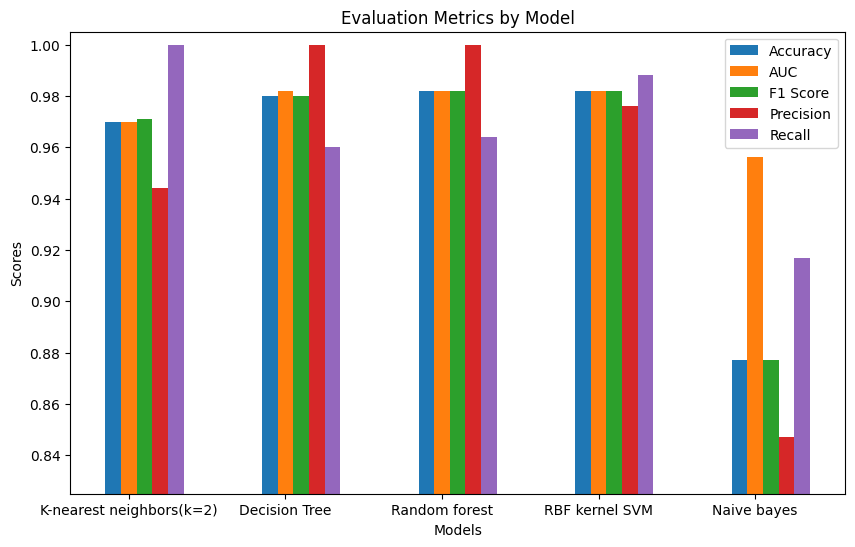

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your data in a table format
models = ['K-nearest neighbors(k=2)',
'Decision Tree',
'Random forest',
'RBF kernel SVM',
'Naive bayes',
]
metrics = ['Accuracy', 'AUC','F1 Score', 'Precision', 'Recall']

# [0.705,0.549,0.289,0.333,0.255],
# [0.645,0.517,0.268,0.26,0.276],
# [0.76, 0.533, 0.518,0.428,0.063],
# [0.72, 0.982,0.522,0.304,0.148],
# [0.6,0.554,0.554,0.285,0.468]

[0.97,0.97,0.971,0.944,1.0],
[0.98,0.982,0.98,1.0,0.96],
[0.982,0.982,0.982,1.0,0.964],
[0.982,0.982,0.982,0.976,0.988],
[0.877,0.956,0.877,0.847,0.917]





scores = np.array([
[0.97,0.97,0.971,0.944,1.0],
[0.98,0.982,0.98,1.0,0.96],
[0.982,0.982,0.982,1.0,0.964],
[0.982,0.982,0.982,0.976,0.988],
[0.877,0.956,0.877,0.847,0.917]])

# Set up the bar graph
bar_width = 0.1
x_pos = np.arange(len(models))

fig, ax = plt.subplots(figsize=(10, 6))  # Increase the figsize


# Plot the bars for each metric and model
for i, metric in enumerate(metrics):
    plt.bar(x_pos + i*bar_width, scores[:, i], width=bar_width, label=metric)

ax.set_ylim(0.825, 1.005)  # Set the y-axis limits


# Add labels and legends
plt.xticks(x_pos + bar_width, models)
plt.title('Evaluation Metrics by Model')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend()

# Show the graph
plt.show()
